# (0) Introduction

<p><b>Overview:</b> To expedite Nudged Elastic Band (NEB) calculations in Quantum Espresso, initials pathways were guessed by using Crystal Analysis by Voronoi Decomposition (CAVD) and Bond Valence Site Energy (BVSE) calculations. This notebook documents the entire process, all the way through performing an NEB calculation in Quantum Espresso. Qualitiavely, the following steps are performed:</p>

1. Check that an input structure is ordered. Otherwise order it. 
2. Determine suitable hyperparamters by running self-consistent field (SCF) calculations on the input structure.
    1. $k_{mesh}$ - the k-space mesh.
    1. $E_{cut,wfc}$ - the wavefunction kinetic energy cutoff.
    1. $E_{cutrho}$ - the charge density and potential kinetic energy cutoff. 
3. With suitable hyperparameters determined, relax the input structure to ~zero pressure.
4. Run the voronoi decomposition algorithm (CAVD) to find void pathways through the structure. 
5. Run the bond valence site energy (BVSE) calculation to estimate the electrostatic force field. 
6. Merge the CAVD and BVSE results to identify low-activation energy pathways. 
7. Select a pathway to examine. 
8. Generate an initial and final image from the pathway, by removing the relevant mobile ion. 
9. Relax the initial and final image to ~zero pressure. 
10. Create intermediate images by combining the CAVD+BVSE results with interpolation:
    1. Framework ions are interpolated between the initial and final images.
    1. Mobile ions are placed along the CAVD+BVSE pathway. 
11. Run & interperet Nudged Elastic Band on the images. 

***
The CAVD and BVSE libraries were originally generated by the Siqi Shi group. The code herein is altered for compability with Quantum Espresso. For VASP compatibility, their repo can be found here: https://gitee.com/shuhebing/cavd/tree/release


***

<p><b>Jupyter-lab Notes:</b> This jupyter notebook makes use of multiple jupyterlab extensions:</p>

* @jupyterlab/toc - for table of contents management
* @aquirdturtle/collapsible_headings - for collapsing sections

<p>Two additional extensions are used for git management:</p>

* @jupyterlab/git - for github integration
* @jupyterlab/nbdime-jupyterlab - for viewing revision history

# (1) Initialization

## (1.1) Imports

In [1]:
# general libraries
import os, sys, re
import copy
import itertools
import json

# utility libraries 
from monty.io import zopen
from shutil import copyfile
from collections import OrderedDict
import tkinter as tk
from tkinter import filedialog

# multi-processing libraries (not currently implemented)
from multiprocessing import Pool
from functools import partial

# dataprocessing and viewing libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# atomic structure environment (ase) libraries 
from ase.build import bulk
from ase.io import espresso
import ase.io

# pymatgen libraries
from pymatgen.io.cif import CifWriter
from pymatgen.io.cif import CifParser
from pymatgen.transformations.standard_transformations import OrderDisorderedStructureTransformation
from pymatgen.transformations.standard_transformations import DiscretizeOccupanciesTransformation
from pymatgen.transformations.standard_transformations import ConventionalCellTransformation
from pymatgen.transformations.standard_transformations import OxidationStateDecorationTransformation
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen import symmetry
from pymatgen import Structure
import pymatgen.io.ase as ase_io
import pymatgen.io.cif as cif_io
import pymatgen.core.periodic_table as pt

# cavd codebase
from cavd.netio import *
from cavd.channel import Channel
from cavd.netstorage import AtomNetwork, connection_values_list
from cavd.local_environment import CifParser_new, LocalEnvirCom
from cavd.get_Symmetry import get_symnum_sites, get_equivalent_vornet,get_labeled_vornet
from cavd.recovery import rediscovery, rediscovery_kdTree, rediscovery_byRad_kdTree, rediscovery_byRad_kdTree_onlyVertex
from cavd import bmd_com
from cavd_bvse.mergecluster import load_voids_channels_from_file, load_struc, load_bvse
from cavd_bvse.non_equivalent_paths import non_equivalent_paths

# bvse & neb libraries
import Structure as customstruc
import BVAnalysis
from bvse_cal import bv_calculation
import pwscf_input
import worker_neb_bvse

# %matplotlib widget

## (1.2) Default Settings
<p>The default file structure is hard coded here. Appropriate folders are automatically generated by changing the top two variables:</p>

* mobile_ion
* cif_filename

| The folders | Description |
| --- | --- |
| cif_input_dir | holds the initial cif file |
| cif_output_dir | holds the ordered cif files |
| cavd_output_dir | holds the calculated voronoi information |
| bvse_output_dir | holds the calculated bond valence site energy information |
| nep_output_dir | holds the calculated non-equivalent paths  |
|  |  |
| scf_input_dir | files for input to HPC for self-consistent field calculations |
| scf_output_dir | output files from HPC for self-consistent field calculations |
|  |  |
| vcrelax_input_dir | files for input to HPC for variable cell relaxation calculations |
| vcrelax_output_dir | output files from HPC for variable cell relaxation calculations |
|  |  |
| relax_input_dir | files for input to HPC for relaxation calculations without using variable cell |
| relax_output_dir | output files from HPC for relaxation calculations without using variable cell |
|  |  |
| neb_input_dir | files for input to HPC for nudged elastic band calculations |
| neb_output_dir | files from HPC for nudged elastic band calculations |

In [2]:
# Default settings - manually set the first two: conducting_ion and cif_filename
mobile_ion = "Li"
cif_filename = 'Li3ErBr6_mp-1222492.cif'
root_name_of_file = cif_filename.replace(".cif", "")


# Automatically generate root directories
root_dictionary = dict(
    cif_input_root = os.path.join(os.getcwd(), '{}_cifs\\'.format(mobile_ion.lower())),
    cif_output_root = os.path.join(os.getcwd(), '{}_cifs_sanitized\\'.format(mobile_ion.lower())),
    cavd_output_root = os.path.join(os.getcwd(), '{}_cavd_outputs\\'.format(mobile_ion.lower())),
    bvse_output_root = os.path.join(os.getcwd(), '{}_bvse_outputs\\'.format(mobile_ion.lower())),
    nep_output_root = os.path.join(os.getcwd(), '{}_nep_outputs\\'.format(mobile_ion.lower())),
    scf_input_root = os.path.join(os.getcwd(), '{}_scf_inputs\\'.format(mobile_ion.lower())),
    scf_output_root = os.path.join(os.getcwd(), '{}_scf_outputs\\'.format(mobile_ion.lower())),
    vcrelax_input_root = os.path.join(os.getcwd(), '{}_vcrelax_inputs\\'.format(mobile_ion.lower())),
    vcrelax_output_root = os.path.join(os.getcwd(), '{}_vcrelax_outputs\\'.format(mobile_ion.lower())),
    relax_input_root = os.path.join(os.getcwd(), '{}_relax_inputs\\'.format(mobile_ion.lower())),
    relax_output_root = os.path.join(os.getcwd(), '{}_relax_outputs\\'.format(mobile_ion.lower())),
    neb_input_root = os.path.join(os.getcwd(), '{}_neb_inputs\\'.format(mobile_ion.lower())),
    neb_output_root = os.path.join(os.getcwd(), '{}_neb_outputs\\'.format(mobile_ion.lower())))

for path in root_dictionary.values():
    try:
        os.mkdir(path)
    except:
        pass

# Automatically generate structure-specific folders
paths_dictionary = dict(
    cif_input_dir = os.path.join(os.getcwd(), '{}_cifs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)),
    cif_output_dir = os.path.join(os.getcwd(), '{}_cifs_sanitized\\{}\\'.format(mobile_ion.lower(), root_name_of_file)),
    cavd_output_dir = os.path.join(os.getcwd(), '{}_cavd_outputs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)),
    bvse_output_dir =  os.path.join(os.getcwd(), '{}_bvse_outputs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)),
    nep_output_dir = os.path.join(os.getcwd(), '{}_nep_outputs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)),
    scf_input_dir = os.path.join(os.getcwd(), '{}_scf_inputs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)),
    scf_output_dir = os.path.join(os.getcwd(), '{}_scf_outputs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)),
    vcrelax_input_dir = os.path.join(os.getcwd(), '{}_vcrelax_inputs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)),
    vcrelax_output_dir = os.path.join(os.getcwd(), '{}_vcrelax_outputs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)),
    relax_input_dir = os.path.join(os.getcwd(), '{}_relax_inputs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)),
    relax_output_dir = os.path.join(os.getcwd(), '{}_relax_outputs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)),
    neb_input_dir = os.path.join(os.getcwd(), '{}_neb_inputs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)), 
    neb_output_dir = os.path.join(os.getcwd(), '{}_neb_outputs\\{}\\'.format(mobile_ion.lower(), root_name_of_file)))

for path in paths_dictionary.values():
    try:
        os.mkdir(path)
    except:
        pass

# (2) CAVD + BVSE
<p>Initialization of the Crystal Analysis by Voronoi Decomposition (CAVD) and Bond Valence Site Energy (BVSE) functions. An example use case is also documented.</p>

## (2.1) Ordering Check
<p>The <b>ordering_check()</b> function determines whether an input structure is ordered. If not, it will attempt to order the structure. The function saves two representations of the structure into the cif_output_dir:</p>

* structure.cif - the structure output using copyfile (if was ordered) or pymatgen.structure.to() (if ordering was required)
* symprec_structure.cif - the structure output using CifWriter with symprec=True

<p><b>Note from Dan:</b> When cif files are examined by orderingCheck and then written to the Li Cifs sanitized folder, a change is made to their formatting where the lines *"_space_group_symop_id"* and "_space_group_symop_operation_xyz" are replaced by "_symmetry_equiv_pos_site_id" and "_symmetry_equiv_pos_as_xyz". CAVD doesn't seem to recognize the former representation of symmetry and so this step is needed to perform the analysis. As of now, the best match with reference data is acheived by using CifParser_New without symprec in CifWriter</p>

In [3]:
def ordering_check(filename=None, \
                   cif_input_dir=paths_dictionary['cif_input_dir'], \
                   cif_output_dir=paths_dictionary['cif_output_dir']):
    """
    Checks the input cif to determine if the structure is ordered.

    If ordered: pass the structure and a symprec representation to the output directory.

    If unordered: attempt to order with OrderDisorderedStructureTransformation(). Then pass
    the structure and a symprec representation to the output directory. 

    Parameters
    ----------
    filename : str
        filename in the form "filename.cif"

    cif_input_dir : str, optional
        Where the input file resides.

    cif_output_dir : str, optional
        Where the output files should go.   

    Raises
    ------
    ValueError
        If ordering could not be achieved. 
    """
    
    # look for the file in the Li Cifs/ folder
    filepath = cif_input_dir + filename

#     stru = Structure.from(filepath)
    
    # pull in structure
    with zopen(filepath, "rt") as f:
        input_string = f.read()
    parser = CifParser_new.from_string(input_string)
    stru = parser.get_structures(primitive=False)[0]
    print("Spacegroup of input: {}".format(stru.get_space_group_info()))

    # if the structure is ordered then just write the .cif to a "sanitized" folder
    if (stru.is_ordered):
        #save raw version
        copyfile((cif_input_dir + filename), (cif_output_dir + filename))
#         w = CifWriter(stru, symprec=None)
#         w.write_file(cif_output_dir + "raw_" + filename)
        
        #save symprec version
        w = CifWriter(stru, symprec=True)
        w.write_file(cif_output_dir + "symprec_" + filename)
        print("Input is ordered")


    # if the structure is not ordered, attempt to order it
    else:
        try:
            # convert input into a conventional cell
            trans = ConventionalCellTransformation()
            stru = trans.apply_transformation(stru)
            
            # convert the conventional cell into an ordered cell
            trans = OrderDisorderedStructureTransformation()
            stru = trans.apply_transformation(stru, return_ranked_list=100)
            
            # use the structureMatcher to knock out equivalent sites
            matcher = StructureMatcher()
            groups = matcher.group_structures([d["structure"] for d in stru])

            # write the lowest energy structure to the "sanitized" folder
            groups[0][0].to(filename=cif_output_dir + filename)
        
            #save symprec version
            w = CifWriter(groups[0][0], symprec=True)
            w.write_file(cif_output_dir + "symprec_" + filename)
            
            print("Input sucessfully ordered")

        except Exception as e:
            # if conversion of an unordered structure fails:
            raise ValueError("Ordering failed: {}".format(e))

## (2.2) CAVD

<p>Use CAVD to pull out the $R_{t}$ values and other parameters, including recovery rate. This version is different from original out_vesta() function in two ways:</p>

1. It includes the faces of the Voronoi cells as potential interstitial sites
2. It calculates the recovery rate of the Voronoi decomposition

In [4]:
def outvesta_fcs(filename=cif_filename, mobile_ion=mobile_ion, ext="", ntol=0.02, lower=0, upper=10, symprec=0.01, \
                 cif_output_dir = paths_dictionary['cif_output_dir'], \
                 cavd_output_dir = paths_dictionary['cavd_output_dir'], \
                 bvse_output_dir=paths_dictionary['bvse_output_dir'],  \
                 scaling=1):
    """
    Runs the cavd process on a structure to determine the voronoi network. 

    Parameters
    ----------
    filename : str
        Filename in the form "filename.cif".

    mobile_ion : str, optional
        The mobile ion. 
    
    ext : str, optional
        An extension that determines whether the function should use the normal 
        cif or the one save with symprec. Values are either "" or "symprec_"
    
    ntol : float, optional
        Tolerance used when constructing the voronoi network. 
    
    lower : float, optional
        Minimum value for void bottlenecks: distance to framework ion surface.

    upper : float, optional
        Maximum value for void bottlenecks: distance to framework ion surface.
        
    symprec : float, optional
        And extension that determines whether the function should use the normal 
        cif or the one save with symprec. Values are either "" or "symprec_"
    
    cif_output_dir : str, optional
        Where the cifs were saved after ordering_check(). 
        
    cavd_output_dir : str, optional
        Where the cavd output files are saved. 
        
    bvse_output_dir : str, optional
        Where output files that relate to the bvse calculation are saved.  

    Returns
    -------
    conn_val : list
        The largest diameter sphere that can pass through the structure.
    
    recover_rate : float
        The percent of mobile_ions that were discovered on voronoi vertices.
        This value should be 1.0. 
    
    stru : pymatgen.core.structure.Structure
        The structure.
    
    Raises
    ------
    ValueError
        If the mobile ion is not in the structure.  
    """
    
    filepath = cif_output_dir + ext + filename

    with zopen(filepath, "rt") as f:
        input_string = f.read()
    parser = CifParser_new.from_string(input_string)
    stru = parser.get_structures(primitive=False)[0]
    
    #attempt on a supercell
    if scaling!=1:
        stru.make_supercell([scaling, scaling, scaling])
    
    sitesym = parser.get_sym_opt()
    species = [str(sp).replace("Specie ", "") for sp in stru.species]
    elements = [re.sub('[^a-zA-Z]', '', sp) for sp in species]
    
    if mobile_ion not in elements:
        raise ValueError("The input mobile ion not in the input structure! Please check it.")
    
    effec_radii, mobile_radius, mobile_alpha, nei_dises, coordination_list = LocalEnvirCom(stru, mobile_ion)
   
    atmnet = AtomNetwork.read_from_RemoveMigrantCif(filepath, mobile_ion, effec_radii, True)
    vornet, edge_centers, fcs, faces = atmnet.perform_voronoi_decomposition(True, ntol)
    
    add_fcs_vornet = vornet.add_facecenters(faces)
    sym_vornet, voids = get_labeled_vornet(add_fcs_vornet, sitesym, symprec)
    voids_abs = []
    
    for void in sym_vornet.nodes:
        voids_abs.append(void[2])
    
    bottlenecks = []
    for bt in sym_vornet.edges:
        bottlenecks.append(bt[2])
    
    fcens = []
    for fc in fcs:
        fcens.append(fc[0])
    
    vorosites = [voids_abs, bottlenecks, fcens]
    recover_rate, recover_state, migrate_mindis = rediscovery_kdTree(stru, mobile_ion, vorosites)
    prefixname = filename.replace(".cif", "")
    newpath = cavd_output_dir + ext + prefixname
    
    # compute the R_T
    conn_val = connection_values_list(newpath + ".resex", sym_vornet)
    channels = Channel.findChannels2(sym_vornet, atmnet, lower, upper, newpath + ".net")
    prefixname = filename.replace(cif_output_dir, "")
    prefixname = prefixname.replace(".cif", "")
    
    # output vesta file for visualization
    newpath = bvse_output_dir + ext + prefixname
    Channel.writeToVESTA(channels, atmnet, newpath)
    
    return conn_val, recover_rate, stru

## (2.3) BVSE

<p>The simple_bvse() function implements three aglorithms:</p> 

1. BVS - Bond Valence Site
2. BVSE - Bond Valence Site Energy
3. BVEL - Bond Valence Site Landscape

<p>The bvse_condition_key here is taken directly from HtMap.py. The config_dict is based on examining the code in HtMap.py. The actual BVSE calcuation happens in line 113. The input for the calculation is the dictionary: bvse_condition.  This dictionary is constructed using config_dict in line 97. I can see that the bv_calculation function requires only 3 pieces of information from the dictionary: transport ion, valence, resolution. By comparison to the bvse_condition_key, it seems pretty likely that config_dict also includes the origin and origin_id.

In config_dict below, the value assigned to the resolution key controls the resolution used for the BVSE calculation. A value of 0.1 (Angstroms) is used to generate values in the reference paper. The computing time at this resolution is 10-15 minutes (on my laptop). The bvse_condition_key resolution value doesn't have an observable effect in the calculations I've performed.</p>

In [5]:
def simple_bvse(filename=cif_filename, cif_output_dir=paths_dictionary['cif_output_dir'], ext="", \
               bvse_condition_key={'origin': 0, 'origin_id': 0, 'transport_ion': 'Li', 'valence': 1, 'resolution': 0.1}, \
               config_dict={'origin': 0, 'origin_id': 0, 'transport_ion': 'Li', 'valence': 1, 'resolution': 0.1}):
    """
    Runs the cavd process on a structure to determine the voronoi network. 

    Parameters
    ----------
    filename : str
        Filename in the form "filename.cif".
    
    cif_output_dir : str, optional
        Where the cifs were saved after ordering_check(). 
        
    ext : str, optional
        An extension that determines whether the function should use the normal 
        cif or the one save with symprec. Values are either "" or "symprec_"
        
    bvse_condition_key : dict, optional
        Conditions used in the bvse calculation. 
        
    config_key : dict, optional
        Conditions used in the bvse calculation. 

    Returns
    -------
    Ea : dictionary
        Activation energies for the BVS, BVSE, and BVEL methods. 
    
    bvse_file : str
        name of the bvse output file
    
    bvse_filedir : str
        location of the bvse output file
        
    bvse : list
        The 1D, 2D, and 3D activation energies for BVSE.   
    """
    cif_filename = cif_output_dir + ext + filename

    bvse_condition = {}
    for k in bvse_condition_key:
        bvse_condition[k] = config_dict[k]
    Ea, bvse_file = bv_calculation(bvse_condition, cif_filename)

    bvse = Ea['BVSE']
    bvel = Ea['BVEL']
    bvse_dict = {'bvse_1d': bvse[0], 'bvse_2d': bvse[1], 'bvse_3d': bvse[2], 'bvel_1d': bvel[0], 'bvel_2d': bvel[1],
                 'bvel_3d': bvel[2]}
    bvse_filedir = bvse_file + '_BVSE.npy'

    return Ea, bvse_file, bvse_filedir, bvse

## (2.4) CAVD+BVSE Wrapper

<p>The cavd_bvse_stabilizer() function first attempts to run simple_bvse on the raw cif file. If this fails, it then attempts to run simple_bvse on the symprec-saved version. It tries three different supercells in an attempt to maxmize the recovery rate.</p>

In [6]:
def cavd_bvse_stabilizer(filename=cif_filename, mobile_ion=mobile_ion, ntol=0.02, lower=0, upper=10, \
                         cif_output_dir = paths_dictionary['cif_output_dir'], \
                         cavd_output_dir = paths_dictionary['cavd_output_dir'], \
                         bvse_output_dir=paths_dictionary['bvse_output_dir']):
    """
    Runs the CAVD process and then BVSE process sequentially on an input structure. 
    If the process fails on the raw structure, then it attempts to run the process
    on the symprec_structure.  
    

    Parameters
    ----------
    filename : str, optional
        Filename in the form "filename.cif".
    
    cif_output_dir : str, optional
        Where the cifs were saved after ordering_check(). 
        
    mobile_ion : str, optional
        The mobile ion. 
    
    ext : str, optional
        An extension that determines whether the function should use the normal 
        cif or the one save with symprec. Values are either "" or "symprec_"
    
    ntol : float, optional
        Tolerance used when constructing the voronoi network. 
    
    lower : float, optional
        Minimum value for void bottlenecks: distance to framework ion surface.

    upper : float, optional
        Maximum value for void bottlenecks: distance to framework ion surface.
        
    symprec : float, optional
        And extension that determines whether the function should use the normal 
        cif or the one save with symprec. Values are either "" or "symprec_"
    
    cif_output_dir : str, optional
        Where the cifs were saved after ordering_check(). 
        
    cavd_output_dir : str, optional
        Where the cavd output files are saved. 
        
    bvse_output_dir : str, optional
        Where output files that relate to the bvse calculation are saved.  

    Returns
    -------
    Ea : dictionary
        Activation energies for the BVS, BVSE, and BVEL methods. 
        
    conn_val : list
        The largest diameter sphere that can pass through the structure.
    
    recover_rate : float
        The percent of mobile_ions that were discovered on voronoi vertices.
        This value should be 1.0. 
    
    ext : str
        The extension that worked. Either "" or "symprec_".
    
    bvse_file : str
        name of the bvse output file
    
    bvse_filedir : str
        location of the bvse output file
        
    bvse : list
        The 1D, 2D, and 3D activation energies for BVSE.
        
    Raises
    ------
    ValueError
        If no representations were compatible with simple_bvse().     
    """
    # try to evaluate the raw file
    extension = ""
    try:
        conn_val, recover_rate, structure = outvesta_fcs(filename, mobile_ion, ext=extension, ntol=ntol, lower=lower, upper=upper, \
                                                        cif_output_dir = cif_output_dir, \
                                                        cavd_output_dir = cavd_output_dir, \
                                                        bvse_output_dir = bvse_output_dir)
        Ea, bvse_file, bvse_filedir, bvse = simple_bvse(filename, ext=extension, cif_output_dir=cif_output_dir)
        return Ea, conn_val, recover_rate, extension, bvse_file, bvse_filedir, bvse
    
    except Exception as e:
        print("Raw structure incompatible with simple_bvse(): {}".format(e))
    
    # if the raw file didn't work, try to evaluate the symprec file
    extension = "symprec_"
    try: 
        recover_rates = []
        structures = []
        # Check three cells: [1x, 1x, 1x],  [2x, 2x, 2x], and [3x, 3x, 3x]
        # Recovery rates sometimes improve at larger supercells
        for i in [0,1,2]:
            # Below vales for lower and upper are specific to Li. Values are taken from CAVD reference paper.
            conn_val, recover_rate, structure = outvesta_fcs(filename, mobile_ion, ext=extension, ntol=ntol, lower=lower, upper=upper, \
                                                            cif_output_dir = cif_output_dir, \
                                                            cavd_output_dir = cavd_output_dir, \
                                                            bvse_output_dir = bvse_output_dir, scaling=(i+1))
            recover_rates.append(recover_rate)
            structures.append(structure)
            if recover_rate==1:
                break
        
        #find the id that had the maximum recovery rate and return that 
        max_rate = max(recover_rates)
        max_idx = recover_rates.index(max_rate)
        w = CifWriter(structures[max_idx], symprec=True)
        w.write_file(cif_output_dir + extension + filename)
        conn_val, recover_rate, structure = outvesta_fcs(filename, mobile_ion, ext=extension, ntol=ntol, lower=lower, upper=upper, \
                                                        cif_output_dir = cif_output_dir, \
                                                        cavd_output_dir = cavd_output_dir, \
                                                        bvse_output_dir = bvse_output_dir)
        Ea, bvse_file, bvse_filedir, bvse = simpleBVSE(filename, ext=extension, cif_output_dir=cif_output_dir)
        return Ea, conn_val, recover_rate, extension, bvse_file, bvse_filedir, bvse
    
    except Exception as e:
        print("Symprec structure incompatible with simple_bvse(): {}".format(e))
    
    # Return None for all values if no representations were compatible with simpleBVSE
    raise ValueError("No representations were compatible with simple_bvse()")

## (2.5) Calculate & Save Non-equivalent Paths

<p>Use non_equivalent_paths() to combine CAVD and BVSE information and generate a set of non equivalent paths. Produce text files with paths and their energy as well as the cif structure associated with the paths.</p>

<p><b>Note:</b> The source code prints all the output paths which is annoying. The quick fix is to comment out all the print statements in the cavd_bvse/cal_all_paths.py module.</p>

In [7]:
def mep_calculator(cif_filename, bvse, mobile_ion, extension, conn_val, \
                  bvse_filedir, \
                  cif_output_dir=paths_dictionary['cif_output_dir'], \
                  cavd_output_dir=paths_dictionary['cavd_output_dir'], \
                  nep_output_dir=paths_dictionary['nep_output_dir']):
    """
    Determines the non-equivalent pathways by examining the CAVD and BVSE
    results.    

    Parameters
    ----------
    cif_filename : str
        Filename in the form "filename.cif".
    
    bvse : list
        The 1D, 2D, and 3D activation energies for BVSE. 
        
    mobile_ion : str
        The mobile ion. 
    
    conn_val : list
        The largest diameter sphere that can pass through the structure.
        
    bvse_filedir : str
        Location of the bvse output file.    
    
    cif_output_dir : str, optional
        Where the cifs were saved after ordering_check(). 
        
    cavd_output_dir : str, optional
        Where the cavd output files are saved. 
        
    nep_output_dir : str, optional
        Where output files should be saved for the non-equivalent paths.  

    Returns
    -------
    mep : cavd_bvse.cal_all_paths.MigrationPaths object
        Stores the various non-equivalent paths. 
    """    
    sanitized_cif_filepath = cif_output_dir + extension + cif_filename
    cavd_filepath = cavd_output_dir + extension + cif_filename.split('.')[0] + '.net'
    print("File Locations:")
    print(sanitized_cif_filepath)
    print(cavd_filepath)
    mep = non_equivalent_paths(sanitized_cif_filepath, bvse_filedir, cavd_filepath, bvse, mobile_ion)
    mep.struc.to('Cif', nep_output_dir + extension + cif_filename.split(".")[0] + "_mepstructure.cif")

    # Save descriptors to output file
    descriptors = copy.deepcopy(Ea)
    if conn_val:
        for axis, value in zip(['a', 'b', 'c'], conn_val):
            descriptors[axis + "_RLFS"] = value
        descriptor_filepath = cavd_output_dir + extension + cif_filename.split('.')[0] + '.json'
    with open(descriptor_filepath, 'w') as f:
        json.dump(descriptors, f)
        
    return mep

## (2.6) Plotting Output Paths

<p> Plot output paths from non_equivalent_paths function overlaid on ion arrangment. A list of numbered paths can be passed into the function to visualize specific paths of interest.</p>

In [8]:
def mep_plot(mep, paths=[]):
    """
    Function for plotting the non-equivalent paths.  
    
    Parameters
    ----------
    mep : cavd_bvse.cal_all_paths.MigrationPaths object
        Stores the various non-equivalent paths. 
    
    paths : list, optional
        The paths that the user wants to plot.
    """        
    #Create subplots for plots of paths and path energies
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    ax3 = fig.add_subplot(2, 2, 3)
     
    #If the paths list is empty, set the value of the paths variable to a range covering the paths in the mep object.
    if not paths:
        paths = range(len(mep.paths))

    #Loop through the specified paths, plot their trajectories on the first two subplots and their energy on the third subplot.
    for path in paths:
        cartesian_path_coords = mep.struc.lattice.get_cartesian_coords(mep.paths[path])
        ax1.plot(cartesian_path_coords[:, 0], cartesian_path_coords[:, 1], cartesian_path_coords[:, 2])
        ax2.plot(cartesian_path_coords[:, 0], cartesian_path_coords[:, 1], cartesian_path_coords[:, 2])
        ax3.plot(mep.pathsenergy[path][:, 0], mep.pathsenergy[path][:, 1])
    
    #Loop through the type of species in the mep objects structure and plot the position of each ion in cartestion coordinates on the first subplot.
    for specie_number, specie in enumerate(mep.struc.types_of_specie):
        specie_coords = np.stack([ion.coords for ion in mep.struc.sites if ion.specie == specie])
        ax1.scatter(specie_coords[:, 0], specie_coords[:, 1], specie_coords[:, 2], label=specie,
                   s=specie.ionic_radius * 100)
        if specie.value == "Li":
            li_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][specie_number]
    
    #Plot just the Li ion positions in cartesian coordinates on the second subplot. Match the color of the Li ion with that in the first subplot.
    li_coords = np.stack([ion.coords for ion in mep.struc.sites if ion.specie.value == 'Li'])
    ax2.scatter(li_coords[:, 0], li_coords[:, 1], li_coords[:, 2], label="Li +",
               s=mep.struc.sites[0].specie.ionic_radius * 100, color=li_color)

    #Set the axes labels and legends.
    ax1.set_xlabel("Angstrom")
    ax1.legend()
    ax2.set_xlabel("Angstrom")
    ax2.legend()
    ax3.set_xlabel("Coordinate")
    ax3.set_ylabel("Energy (eV)")

## (2.7) Example: Full CAVD + BVSE Pipeline

<p> Using the cif_filename set in <i>(1.2) Default Settings</i> - do the following:</p>

1. <b>ordering_check(cif_filename)</b> - check file, do disorder-order conversion if necessary, and save the two versions. 
2. <b>cavd_bvse_stabilizer()</b>
    1. <b>outvesta_fcs(cif_filename)</b> - determine the voronoi sites and paths.
    2. <b>simple_bvse(cif_filename)</b> - calculate the bond valence site energy landscape.
3. <b>mep_calculator()</b> - calculate the non-equivalent paths. 
4. <b>mep_plot(mep)</b> - plot the non-equivalent paths.

<p><b>Note:</b> This takes 10-15 minutes to run on my laptop with 0.1 Angstrom resolution.</p>

In [9]:
# run ordering_check()
# creates two potentially viable structures named: raw_+cif_filename.cif, and symprec_+cif_filename.cif
ordering_check(cif_filename)

# run cavd_bvse_stabilizer() on the input structure
# the functon runs CAVD+BVSE on the two potentially viable structures, in order
# for the symprec_ structure it creates supercells to try to optimize the recover_rate
# returns results for whichever structure works first: raw_ > symprec_ (symprec is the last resort)
# the extension that works is returned
Ea, conn_val, recover_rate, extension, bvse_file, bvse_filedir, bvse = cavd_bvse_stabilizer(cif_filename, 'Li', ntol=0.02, lower=0, upper=10)

# update the cif filename if necessary (if a symprec version is used)
cif_filename = extension+cif_filename

print("CAVD conn_vals are: {}".format(conn_val))
print("BVSE Ea values are: {}".format(Ea))

Spacegroup of input: ('C2', 5)
Input is ordered
CAVD conn_vals are: [0.5665063487108177, 0.5665063487108177, 0.5085744883024146]
BVSE Ea values are: {'BVS': [0.712890625, 0.712890625, 0.8203125], 'BVSE': [0.361328125, 0.361328125, 0.390625], 'BVEL': [0.7421875, 0.7421875, 0.80078125]}


In [11]:
mep=mep_calculator(cif_filename, bvse, mobile_ion, extension, conn_val, bvse_filedir)

File Locations:
C:\Users\forre\Box Sync\Python Work\See Lab\Material_Discovery_Repo\li_cifs_sanitized\Li3ErBr6_mp-1222492\Li3ErBr6_mp-1222492.cif
C:\Users\forre\Box Sync\Python Work\See Lab\Material_Discovery_Repo\li_cavd_outputs\Li3ErBr6_mp-1222492\Li3ErBr6_mp-1222492.net


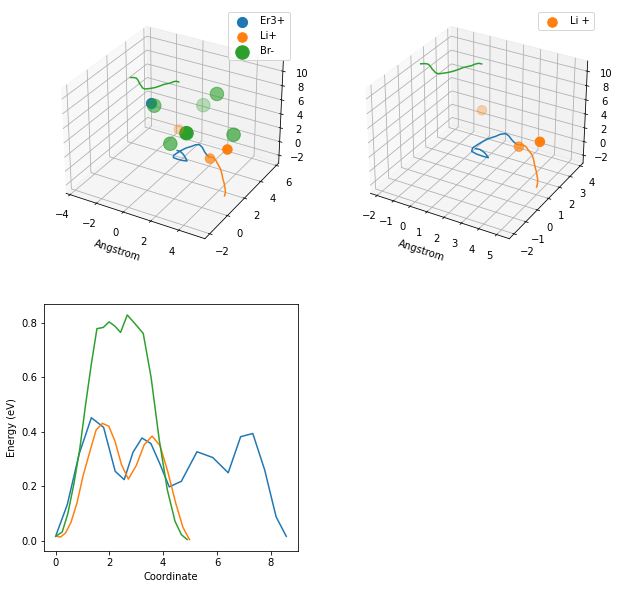

In [12]:
mep_plot(mep)

# (3) NEB Preparation

<p>This section describes the process for generating input files for NEB calculations based on initial pathways determined by the CAVD + BVSE pipeline. If NEB calculations are required for an initial pathway not included in the output from CAVD+BVSE (mep_calculator), some steps may be needed to be performed manually.</p>

## (3.1) Generate SCF Input File

<p>Generating SCF input files to perform convergence testing on nominal unit cell.</p>

In [13]:
def create_qe_scf(cif_filename, ecutwfc, ecutrho, kpoints, mobile_ion, \
                  cif_output_dir = paths_dictionary['cif_output_dir'], \
                  scf_input_dir = paths_dictionary['scf_input_dir']):
    """
    Creates a quantum espresso compatible input for doing scf relaxation.
    The resulting file is then uploaded to the HPC.

    Parameters
    ----------
    cif_filename : str, optional
        Filename in the form "filename.cif".
    
    ecutwfc : list, optional
        The 1D, 2D, and 3D activation energies for BVSE. 
        
    ecutrho : str, optional
        The mobile ion. 
    
    kpoints : tuple
        The largest diameter sphere that can pass through the structure.
        
    mobile_ion : str
        The mobile ion.     
    
    cif_output_dir : str, optional
        Where the cifs were saved after ordering_check(). 
        
    scf_input_dir : str, optional
        Where the files will be saved for upload to the HPC. 
    """    
    
    
    filepath = os.path.join(os.getcwd(), cif_output_dir + cif_filename)
    structureName = cif_filename.replace(".cif", "")

    # Create QE Input classes
    scf_input = pwscf_input.PWscfInput(ase.io.read(filepath))

    # Set directory that contains pseudopotentials for relevant species
    pseudo_dir = '/central/groups/SeeGroup/qe_pseudopotentials/'
    scf_input.control.settings.pseudo_dir = pseudo_dir

    # Set mass and pseudo potential file for each specie type
    mass_table = pd.read_table(os.path.join(os.getcwd(), 'elements.dat'), index_col=0, names=['Elements', 'Mass'],
                               usecols=[1, 4]).drop_duplicates()

    for root, dirs, files in os.walk(os.path.join(os.getcwd(), 'pseudopotentials')):
        pseudo_files = files

    sorted_pseudo_files = []
    for specie_num, specie in enumerate(scf_input.atomic_species.symbol):
        pseudo_found = False
        for pseudo in pseudo_files:
            if pseudo.split('.')[0] == specie:
                sorted_pseudo_files.append(pseudo)
                pseudo_found = True
        if not pseudo_found:
            raise ValueError("A pseudopotential for {} was not found in the pseduo directory".format(specie))
        scf_input.atomic_species.mass[specie_num] = mass_table.loc[specie, 'Mass']
    scf_input.atomic_species.pseudo_potential = np.array(sorted_pseudo_files)

    # Set calculation to SCF
    scf_input.control.settings.calculation = 'scf'

    # Set desired ecutwfc, ecutrho, kpoints
    # SHOULD EDIT THIS SO THAT DEFAULT IS THE VALUE SPECIFIED BY PSEUDOPOTENTIAL
    scf_input.system.ecut.ecutwfc = ecutwfc
    scf_input.system.ecut.ecutrho = ecutrho
    scf_input.kpoints.nk = kpoints

    # Write input file to ./SCF_inputs directory
    scf_input.write_input(
        scf_input_dir + '{}_ecutwfc{}ecutrho{}_k{}{}{}.in'.format(structureName, ecutwfc, ecutrho, kpoints[0],
                                                                   kpoints[1], kpoints[2]))

## (3.2) Example SCF Input Generation

<p>The files generated will be located in the scf_input_dir.</p>

In [14]:
for i in [40, 60, 80, 100, 120, 140, 160]:
    create_qe_scf(cif_filename=cif_filename, ecutwfc=i, ecutrho=i*5, kpoints=[4, 2, 4], mobile_ion=mobile_ion)

## (3.3) Parsing SCF Outputs

<p>SCF output files from quantum espresso (QE) are not readily readable. The following three functions are useful:</p>
    
1. <b>parse_scf_output()</b> - function parses the QE output file and identifies the converged parameters.
2. <b>scf_output_to_df()</b> - function loads the converged paramters into a dataframe.
3. <b>higlight_convergence()</b> - function highlights rows that are converged. 

<p><b>Note:</b> Converged is taken to mean that the total_energy_per_atom (eV) is <3 meV. The highlight_convergence() function assumes that the lowest total_energy_per_atom value is the converged value, and bases all calculations off of that assumption. Make sure to manually check the total_energy_per_atom column for a converged value.</p>

In [15]:
def parse_scf_output(out_filename):
    #boolean to handle the cases where convergence is not achieved 
    convergence_boolean = False
    
    with open(out_filename, "rt") as scf_file:
        lines = [line for line in scf_file.readlines() if line.strip()]

    scf_dic = {}
    
    #regular expression to find kpoint in file name
    res = re.search(r'_k\d{3}_', out_filename)
    scf_dic['kpoints'] = (int(res[0][2]), int(res[0][3]), int(res[0][4]))

    for line in lines:
        split_line = line.split()
        if split_line[0] == '!':
            scf_dic['total_energy (Ry)'] = line.split()[-2]
            #set convergence to true if this line exists
            convergence_boolean = True
        elif 'P=' in split_line:
            scf_dic['total_pressure (kBar)'] = line.split()[-1]
        elif split_line[0] == 'kinetic-energy':
            scf_dic['wfc_cutoff (Ry)'] = float(split_line[-2])
        elif split_line[0] == 'charge':
            scf_dic['rho_cutoff (Ry)'] = float(split_line[-2])
        elif split_line[0:3] == ['number', 'of', 'k']:
            scf_dic['ibz_kpoint'] = split_line[4]
        elif split_line[0:3] == ['number', 'of', 'atoms/cell']:
            scf_dic['atoms_per_cell'] = split_line[-1]
        else:
            continue
    
    # True: calculate the total energy per atom
    # False: set the appropriate columns to None - signifying that convergence wasn't reached
    if convergence_boolean:
        scf_dic['total_energy_per_atom (eV)'] = (float(scf_dic['total_energy (Ry)']) / float(scf_dic['atoms_per_cell'])) * 13.6056980659
    else:
        scf_dic['total_energy (Ry)'] = None
        scf_dic['total_pressure (kBar)'] = None
        scf_dic['atoms_per_cell'] = None
        scf_dic['total_energy_per_atom (eV)'] = None
    return scf_dic

In [16]:
def scf_output_to_df(convergence=0.003, scf_output_dir = paths_dictionary['scf_output_dir']):
    
    # tk commands for file dialog window that allows for multiple uploads
    root = tk.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    filenames = filedialog.askopenfilename(multiple=True, initialdir=scf_output_dir) 
#     %gui tk
#     root.update()
    
    scf_data_rows = []

    for file in filenames:
        scf_dic = parse_scf_output(file)
        scf_data_rows.append(scf_dic)

    scf_dataframe = pd.DataFrame(scf_data_rows)

    #label all rows that are converged - this assumes that a converged value is in the dataframe
    scf_dataframe["energy convergence? (<3 meV)"] = (scf_dataframe[scf_dataframe.columns[7]]-scf_dataframe[scf_dataframe.columns[7]].min())<convergence
    
    return scf_dataframe

In [17]:
# helper function to highlight the converged rows
def highlight_convergence(df, threshold, column):
    is_converged = pd.Series(data=False, index=df.index)
    is_converged[column] = df.loc[column]
    return ['background-color: yellow' if is_converged.any() else '' for v in is_converged]

## (3.4) Example Parsing SCF Outputs

In [18]:
scf_df = scf_output_to_df()

In [19]:
# sort by kpoints, wfc_cutoff, rho_cutoff
scf_df.sort_values([scf_df.columns[0], scf_df.columns[2], scf_df.columns[3]]).style.apply(highlight_convergence, threshold=1.0, column=scf_df.columns[8], axis=1)

,kpoints,atoms_per_cell,wfc_cutoff (Ry),rho_cutoff (Ry),ibz_kpoint,total_energy (Ry),total_pressure (kBar),total_energy_per_atom (eV),energy convergence? (<3 meV)
0,"(1, 1, 1)",None,40.000000,200.000000,1,None,None,nan,False
6,"(1, 1, 1)",20,60.000000,300.000000,1,-6740.41628936,-3.04,-4585.403444,False
12,"(1, 1, 1)",20,80.000000,400.000000,1,-6740.48545380,-2.49,-4585.450495,False
18,"(1, 1, 1)",20,100.000000,500.000000,1,-6740.49333653,-0.01,-4585.455858,False
25,"(1, 1, 1)",20,120.000000,600.000000,1,-6740.49870715,0.04,-4585.459511,False
33,"(1, 1, 1)",20,140.000000,700.000000,1,-6740.49979007,0.55,-4585.460248,False
39,"(1, 1, 1)",20,160.000000,800.000000,1,-6740.50042763,0.39,-4585.460682,False
1,"(2, 1, 2)",None,40.000000,200.000000,4,None,None,nan,False
7,"(2, 1, 2)",20,60.000000,300.000000,4,-6740.47204991,-7.15,-4585.441377,False
13,"(2, 1, 2)",20,80.000000,400.000000,4,-6740.54116538,-6.60,-4585.488395,False


<p><b>Ouput data to excel if needed:</b></p>

In [12]:
scf_df.sort_values([scf_df.columns[0], scf_df.columns[2], scf_df.columns[3]]).to_excel(scf_output_dir+root_name_of_file+"cutoff_exploration.xlsx")

## (3.5) Generate vc-Relax Input

<p><b>create_qe_vcrelax()</b> creates the QE input file required to relax the nominal unit cell. The input file is saved in the <i>vcrelax_input_dir</i>. The function can work in two ways:</p>

1. create_qe_vcrelax() - will prompt the user to select one of the files in scf_output_dir. The function will then use regular expressions to match the kpoints, ecutwfc, and ecutrho values of the input. An appropriate QE input is then calculated based on the cif_filename. 
2. create_qe_vcrelax(cif_filename=?, ecutwfc=?, ecutrho=?, kpoints=(?,?,?)) - An appropriate QE input is generated from the user defined inputs. 

In [20]:
def create_qe_vcrelax(cif_filename=cif_filename, ecutwfc=None, ecutrho=None, kpoints=None, mobile_ion='Li', \
                      cif_output_dir=paths_dictionary['cif_output_dir'], \
                      scf_output_dir=paths_dictionary['scf_output_dir'], \
                      vcrelax_input_dir=paths_dictionary['vcrelax_input_dir']):

    filepath = cif_output_dir+cif_filename
    
    # if no arguments are passed to the function, then match the paramaters of an scf_ouput file
    if ecutwfc==None:
        # tk commands for file dialog window that allows for one upload
        root = tk.Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)
        scf_filepath = filedialog.askopenfilename(multiple=False, initialdir=scf_output_dir) 
    #     %gui tk
    #     root.update()

        #regular expression to find kpoint in file name
        res = re.search(r'_k\d{3}_', scf_filepath)
        kpoints = (int(res[0][2]), int(res[0][3]), int(res[0][4]))

        # regular expression to find cutoff for wfc
        res = re.search(r'ecutwfc\d{3}', scf_filepath)
        ecutwfc = int(res[0][-3:])

        # regular expression to find cutoff for rho
        res = re.search(r'ecutrho\d{3}', scf_filepath)
        ecutrho = int(res[0][-3:])

    structureName = cif_filename.replace(".cif", "")

    # Create QE Input classes
    vcrelax_input = pwscf_input.PWscfInput(ase.io.read(filepath))

    # Set directory that contains pseudopotentials for relevant species
    pseudo_dir = '/central/groups/SeeGroup/qe_pseudopotentials/'
    vcrelax_input.control.settings.pseudo_dir = pseudo_dir

    # Set mass and pseudo potential file for each specie type
    mass_table = pd.read_table(os.path.join(os.getcwd(), 'elements.dat'), index_col=0, names=['Elements', 'Mass'],
                               usecols=[1, 4]).drop_duplicates()

    for root, dirs, files in os.walk(os.path.join(os.getcwd(), 'pseudopotentials')):
        pseudo_files = files

    sorted_pseudo_files = []
    for specie_num, specie in enumerate(vcrelax_input.atomic_species.symbol):
        for pseudo in pseudo_files:
            if pseudo.startswith(specie):
                sorted_pseudo_files.append(pseudo)
        vcrelax_input.atomic_species.mass[specie_num] = mass_table.loc[specie, 'Mass']
    vcrelax_input.atomic_species.pseudo_potential = np.array(sorted_pseudo_files)

    # Set calculation to relax
    vcrelax_input.control.settings.calculation = 'vc-relax'
    vcrelax_input.control.settings.prefix = structureName + '_vc-relax'
    vcrelax_input.control.ion_relax.etot_conv_thr = 1E-6
    vcrelax_input.control.ion_relax.forc_conv_thr = 1E-5
    
    # Set desired ecutwfc, ecutrho, kpoints
    # SHOULD EDIT THIS SO THAT DEFAULT IS THE VALUE SPECIFIED BY PSEUDOPOTENTIAL
    vcrelax_input.system.ecut.ecutwfc = ecutwfc
    vcrelax_input.system.ecut.ecutrho = ecutrho
    vcrelax_input.kpoints.nk = kpoints
    
    # Write input file to ./SCF_inputs directory
    filename = vcrelax_input_dir+'{}_ecutwfc{}ecutrho{}_k{}{}{}_vc-relax.in'.format(structureName, ecutwfc, ecutrho, kpoints[0],
                                                                       kpoints[1], kpoints[2])
    vcrelax_input.write_input(filename)
    
    # Output from write_input() is putting quotations around the pressure cutoffs
    # This routine removes the quotations 
    with open(filename, "rt") as vcrelax_file:
        lines = [line for line in vcrelax_file.readlines()]
        for idx, line in enumerate(lines):
            try:
                split_line = line.split()
                # look for the lines starting with 'press' and 'press_conv_thr'
                if split_line[0] == 'press' or 'press_conv_thr':
                    # replace the ' with nothing
                    lines[idx] = line.replace("'", "")
                else:
                    pass
            except:
                pass
    with open(filename, "w") as vcrelax_file:
        vcrelax_file.writelines(lines)

In [21]:
# mode 1 - pass nothing
create_qe_vcrelax()

# mode 2 - define values manually
# create_qe_vcrelax(cif_filename=cif_filename, ecutwfc=120, ecutrho=600, kpoints=(4,2,4), mobile_ion='Li')

## (3.6) Parse vc-Relax Output

<p> The subsequent two functions are used for parsing the vcrelax_output from quantuam espresso:</p>

1. <b>get_esspresso_structure()</b> - Helper function that grabs a specified structure in the vcrelax_output file.
2. <b>vcrelax_to_cif()</b> - Constructs pymatgen structure from the get_espresso_structure() helper. Charge decorates the structure and saves it as a cif. Returns the name of the saved cif to update cif_filename. 

<p><b>Outputs:</b> A copy of the cif is saved in the vcrelax_output_dir and the cif_input_dir (for subsequent use in the CAVD+BVSE pipeline). Update cif_filename by running:</p>

```cif_filename = vcrelax_to_cif()```

In [22]:
def get_espresso_structure(qe_filename, struc_index):
    
    with open(qe_filename, "r") as f:
        output_strucs = [struc for struc in espresso.read_espresso_out(f, slice(-1))]

    ase_pymatgen_adapter = ase_io.AseAtomsAdaptor()

    return ase_pymatgen_adapter.get_structure(output_strucs[struc_index])

In [23]:
def vcrelax_to_cif(qe_filename=None, struc_index=-1, cif_input_dir=paths_dictionary['cif_input_dir'], vcrelax_output_dir=paths_dictionary['vcrelax_output_dir']):
    
    if qe_filename == None:
        # tk commands for file dialog window that allows for one upload
        root = tk.Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)
        qe_filename = filedialog.askopenfilename(multiple=False, initialdir=vcrelax_output_dir) 
    #     %gui tk
    #     root.update()

    struc = get_espresso_structure(qe_filename, struc_index)

    species = struc.species
    coords = struc.frac_coords

    orig_lattice = struc.lattice.matrix
#     conversion = 0.529177249
    conversion=1
    lattice = orig_lattice * conversion

    vcrelax_stru = Structure(lattice=lattice, species=species, coords=coords)
    
    # attempt to decorate with oxidation states using pymatgen's built-in method
    vcrelax_stru.add_oxidation_state_by_guess()
    
    # if pymatgen's method failed, then manually use the OxidationStateDecorationTransformation()
    if vcrelax_stru.charge != 0.0:
        oxidation_dictionary = {"H":1, "Li": 1, "Na":1, "K":1, "Rb": 1, "Cs":1, "Be":2, "Mg":2, "Ca":2, \
                        "Sr":2, "Ba":2, "Ra": 2, "B":3, "Al":3, "Ga":3, "In":3, "Tl":3, \
                        "C":4, "Si": 4, "Ge": 4, "Sn": 4, "Pb": 4, "N":-3, "P":5, "As":5, \
                        "Sb": 5, "Bi":5, "O":-2, "S":-2, "Se":-2, "Te":-2, "Po":-2, "F":-1, \
                       "Cl":-1, "Br":-1, "I":-1, "Sc":3, "Y":3, "Lu":3, "Ti":4, "Zr":4, "Hf":4, \
                       "V":5, "Nb":5, "Ta":5, "Cr":6, "Mo":4, "W":6, "Mn":7, "Tc":7, "Re":7, \
                       "Fe":3, "Ru":3, "Os":3, "Co": 3, "Rh":3, "Ir":3, "Cu":2, "Ag":1, "Au":3, \
                       "Zn":2, "Ni":2, "Cd":2, "Hg":2, "La":3, "Ce":3, "Pd":2, "Pm":3, "Ho":3, \
                        "Eu":3, "Np":3, "Pu":4, "Gd":3, "Sm":2, "Tb":3, "Tm":3, "Yb":3, "Ac":3, \
                       "Dy": 3, "Er":3, "Pr":3, "U":6, "Pt":2, "Nd":3, "Th":4, "Pa":5}
        trans = OxidationStateDecorationTransformation(oxidation_dictionary)
        trans.apply_transformation(vcrelax_stru)
        
    if vcrelax_stru.charge == 0:
        file_name = vcrelax_stru.composition.reduced_formula + '_vcr' + '.cif'
        vcrelax_stru.to("cif", os.path.join(os.path.dirname(qe_filename), file_name))
        vcrelax_stru.to("cif", cif_input_dir+file_name)
        return file_name
        
    else:
        raise ValueError("Charge decoration failed!")

In [24]:
cif_filename = vcrelax_to_cif()
print("The new cif_filename is {}".format(cif_filename))

The new cif_filename is Li3ErBr6_vcr.cif


## (3.6) CAVD+BVSE on Relaxed Cell

<p> Run the following functions on the relaxed cell:</p>

1. <b>ordering_check(cif_filename)</b> - check file, do disorder-order conversion if necessary (it shouldn't be), and save the two versions. 
2. <b>cavd_bvse_stabilizer()</b>
    1. <b>outvesta_fcs(cif_filename)</b> - determine the voronoi sites and paths.
    2. <b>simple_bvse(cif_filename)</b> - calculate the bond valence site energy landscape.
3. <b>mep_calculator()</b> - calculate the non-equivalent paths. 

<p>The required functions are initialized in section 2:</p>

* <i>(2.1) Ordering Check</i>
* <i>(2.2) CAVD</i>
* <i>(2.3) BVSE</i>
* <i>(2.4) CAVD+BVSE Wrapper</i>
* <i>(2.5) Calculate & Save Non-equivalent Paths</i>



In [26]:
# Note: If vcrelax_to_cif() hasn't been run, then the cif_filename variable needs to be manually set to target the vcr structure
# cif_filename = "xyz_vcr.cif"

# run ordering_check to ensure that the structure is ordered and generate an output in the cif_output_dir
ordering_check(cif_filename)

# Below vales for lower and upper are specific to Li. Values are taken from CAVD reference paper.
Ea, conn_val, recover_rate, extension, bvse_file, bvse_filedir, bvse = cavd_bvse_stabilizer(cif_filename, 'Li', ntol=0.02, lower=0, upper=10)

# update the cif_filename if the symprec structure was used
cif_filename = extension+cif_filename

mep = mep_calculator(cif_filename, bvse, mobile_ion, extension, conn_val, bvse_filedir)

print("The new cif_filename is {}".format(cif_filename))
print("CAVD conn_vals are: {}".format(conn_val))
print("BVSE Ea values are: {}".format(Ea))

Spacegroup of input: ('C2', 5)
Input is ordered
File Locations:
C:\Users\forre\Box Sync\Python Work\See Lab\Material_Discovery_Repo\li_cifs_sanitized\Li3ErBr6_mp-1222492\Li3ErBr6_vcr.cif
C:\Users\forre\Box Sync\Python Work\See Lab\Material_Discovery_Repo\li_cavd_outputs\Li3ErBr6_mp-1222492\Li3ErBr6_vcr.net
The new cif_filename is Li3ErBr6_vcr.cif
CAVD conn_vals are: [0.5867830037928552, 0.5413152835297368, 0.5062432197258973]
BVSE Ea values are: {'BVS': [0.60546875, 0.732421875, 0.849609375], 'BVSE': [0.322265625, 0.361328125, 0.390625], 'BVEL': [0.68359375, 0.751953125, 0.810546875]}


# (4) NEB Process

<p>The previous steps yield prospective ionic migration pathways through the relaxed structure. Now we should:</p>

1. Choose a plausible pathway to run nudged elastic band (NEB) on. 
2. Create the boundary cifs - the cifs where the mobile ion is absent at the startpoint and endpoint.
3. Relax the boundary cifs.
4. Create the intermediate images.

## (4.1) Examine Plausible Pathways

<p>Three functions are used to examine the plausible pathways:</p>

1. <b>parse_path_struc()</b> - Get saved filepaths. Data comes from the structure in <i>cif_output_dir</i> and the saved filepaths in <i>nep_output_dir</i>.
2. <b>find_closest_ion()</b> - Finds the closest ions in the relaxed cell to the endpoints of the path. This is needed because the voronoi vertices seldom match exactly with the mobile ion positions. 
3. <b>export_path_info()</b> - Analyzes the structure symmetry and returns relevant path info: start_ion, end_ion, start_wyck, end_wyck, Ea, path_length. Exports as a csv and returns a pandas dataframe. 

In [27]:
def parse_path_struc(cif_filename, \
                     cif_output_dir=paths_dictionary['cif_output_dir'], \
                     nep_output_dir=paths_dictionary['nep_output_dir']):

    filename = cif_filename.replace(".cif", "")
    
    # Get filepath to text file with path info
    paths_filepath = cif_output_dir + filename + "_nonequalpaths.txt"

    # Get filepath to corresponding cif file
    cif_filepath = nep_output_dir + filename + "_mepstructure.cif"

    # Read path file and put info into dictionary
    paths_dic = {}
    with open(paths_filepath, "rt") as paths_file:
        for line in paths_file.read().splitlines()[:-1]:
            if line.split()[0] == "nonequalpath":
                temp_pathid = line.split()[1].split(":")[-1]
                paths_dic[temp_pathid] = []
            else:
                paths_dic[temp_pathid].append([float(i) for i in line.split()[1:]])

    for path in paths_dic:
        paths_dic[path] = np.array(paths_dic[path])

    #  Sort paths by increasing activation energy (max - min energy along path)
    sorted_paths = {key: paths_dic[key] for key in sorted(paths_dic, key=lambda x: abs(max(paths_dic[x][:, -1]) -
                                                                                       min(paths_dic[x][:, -1])))}
    # Parse cif file and create structure. Pymatgen Structure method "from_file" is being used instead of CifParser as
    # the former does not change order of lattice constants or symmetry
    stru = Structure.from_file(cif_filepath)

    return sorted_paths, stru

In [28]:
def find_closest_ions(sorted_paths, struc, des_path, mobile_ion=mobile_ion, supercell=None, shift=None):

    species = [str(sp).replace("Specie ", "") for sp in struc.species if sp.element.value != mobile_ion]

    start_path_coords_frac = sorted_paths[str(des_path)][2, :-2]
    end_path_coords_frac = sorted_paths[str(des_path)][-3, :-2]

    for i in range(3):
        if start_path_coords_frac[i] < 0.0:
            start_path_coords_frac[i] += 1
        elif start_path_coords_frac[i] > 1.0:
            start_path_coords_frac[i] -= 1
        else:
            continue
        if end_path_coords_frac[i] < 0.0:
            end_path_coords_frac[i] += 1
        elif end_path_coords_frac[i] > 1.0:
            end_path_coords_frac[i] -= 1
        else:
            continue

    temp_struc_initial = Structure(struc.lattice, struc.species, struc.frac_coords)
    temp_struc_final = Structure(struc.lattice, struc.species, struc.frac_coords)

    for specie in struc.types_of_specie:
        if specie.element.value == mobile_ion:
            des_specie = specie

    if supercell:
        print('Using supercell: ', supercell)
        temp_struc_initial.make_supercell(supercell)
        temp_struc_final.make_supercell(supercell)
        if shift:
            print('Using shift: ', shift)
            start_path_coords_frac = (start_path_coords_frac + shift) / supercell
            end_path_coords_frac = (end_path_coords_frac + shift) / supercell
        else:
            start_path_coords_frac = start_path_coords_frac / supercell
            end_path_coords_frac = end_path_coords_frac / supercell

    temp_struc_initial.remove_species(species)
    temp_struc_initial.append(species=des_specie, coords=start_path_coords_frac, coords_are_cartesian=False)
    distances = temp_struc_initial.distance_matrix + np.identity(temp_struc_initial.num_sites) * 100
    start_closest_ion = np.argmin(distances[:, -1])

    temp_struc_final.remove_species(species)
    temp_struc_final.append(species=des_specie, coords=end_path_coords_frac, coords_are_cartesian=False)
    distances = temp_struc_final.distance_matrix + np.identity(temp_struc_final.num_sites) * 100
    end_closest_ion = np.argmin(distances[:, -1])

    return start_closest_ion, end_closest_ion

In [29]:
def export_path_info(paths, struc, mobile_ion=mobile_ion, \
                     nep_output_dir=paths_dictionary['nep_output_dir']):

    sym_info = symmetry.analyzer.SpacegroupAnalyzer(struc).get_symmetry_dataset()

    path_info = []

    for path in paths.keys():
        start_ion, end_ion = find_closest_ions(paths, struc, int(path), mobile_ion)
        start_wyck = sym_info['wyckoffs'][start_ion]
        end_wyck = sym_info['wyckoffs'][end_ion]
        Ea = max(paths[path][:, -1]) - min(paths[path][:, -1])
        path_length = paths[path][-1, -2]
        path_info.append({'Path': path, 'Start_ion': start_ion, 'End_ion': end_ion, 'Start_Wyckoff_site': start_wyck,
                        'End_Wyckoff_site': end_wyck, 'Activation_energy (eV)': Ea, 'Path_length': path_length})

    path_info_df = pd.DataFrame(path_info)
    path_info_df.to_csv(nep_output_dir + struc.composition.reduced_formula + "_pathinfo.csv")
    
    return path_info_df

In [30]:
sorted_paths, stru = parse_path_struc(cif_filename)
path_info_df = export_path_info(sorted_paths, stru)
print("{} paths identified.".format(len(sorted_paths)))
path_info_df

9 paths identified.


,Path,Start_ion,End_ion,Start_Wyckoff_site,End_Wyckoff_site,Activation_energy (eV),Path_length
0,0,1,0,a,a,0.419517,9.470734
1,1,4,0,a,a,0.424082,8.901577
2,7,2,4,b,a,0.447797,5.010649
3,4,5,3,b,a,0.451379,5.097835
4,2,2,0,b,a,0.459658,4.872090
5,8,5,2,b,b,0.696348,8.438496
6,5,1,2,a,b,0.721528,8.475138
7,3,5,0,b,a,0.736288,8.707198
8,6,5,1,b,a,0.884447,5.126517


## (4.2) Create Pathway Cifs

<p>Convert a selected path to a cif for inspection.</p>

1. <b>path_to_cif()</b> - Structure information comes from <i>cif_output_dir</i> while pathway information comes from <i>nep_output_dir</i>. The resulting cif is saved in the <i>nep_output_dir</i>.

In [31]:
def path_to_cif(cif_filename, desired_paths=[], res=1, \
                cif_output_dir=paths_dictionary['cif_output_dir'], \
                nep_output_dir=paths_dictionary['nep_output_dir']):

    sorted_paths, struc = parse_path_struc(cif_filename)

    filename = cif_filename.replace(".cif", "")
    
    # Create filepath for output cif file
    final_struct_cif_filename = nep_output_dir + struc.composition.reduced_formula + "_mep" + ".cif"

    # Create fake vesta atoms for path
    fake_vesta_atoms = []
    vesta_safe_letters = ["A", "D", "E", "G", "J", "L", "M", "Q", "R", "T", "X", "Y", "Z"]
    for letter1 in vesta_safe_letters:
        for letter2 in vesta_safe_letters:
            fake_vesta_atoms.append("{}{}".format(letter1, letter2))
    fake_vesta_atoms = [x for x in fake_vesta_atoms if x not in [y.upper() for y in dir(pt.Element)]]

    # Create temporary structure that dummy atoms representing paths will be appended to
    temp_struc = Structure(struc.lattice, struc.species, struc.frac_coords)

    if not desired_paths:
        desired_paths = sorted_paths.keys()

    for path_rank, path in enumerate(sorted_paths.keys()):
        if path in desired_paths:
            for index, path_data in enumerate(sorted_paths[path]):
                if index % res == 0:
                    temp_struc.append(species=fake_vesta_atoms[path_rank],
                                    coords=struc.lattice.get_cartesian_coords(path_data[:-2]), coords_are_cartesian=True)

    temp_struc.to('Cif', final_struct_cif_filename)

In [37]:
path_to_cif(cif_filename)

## (4.3) Create Boundary Cifs

<p>Create boundary cifs for the selected path. Two cifs are generated, with the the initial and final position respectively depopulated.</p>

<p><b>Notes:</b></p>

* Ideally, the depopulated sites should be 10+ angstroms from their periodic image. Creation of a supercell may be required to achieve 10+ angroms of separation.
* Paths should not leave the unit cell. Apply a shift to make sure paths do not.  

<p><b>Functions:</b></p>

1. <b>create_boundary_structures()</b> - The resultings cifs are saved in the <i>neb_input_dir</i>.

In [33]:
def create_boundary_structures(cif_filename=cif_filename, des_path=0, mobile_ion=mobile_ion, supercell=None, shift=None, neb_input_dir=paths_dictionary['neb_input_dir']):

    filename = cif_filename.format(".cif", "")
    
    # WILL NEED TO CONSIDER CASES WHERE PATH EXTENDS OUTSIDE CELL

    # Grab structure
    sorted_paths, struc = parse_path_struc(cif_filename)

    # Find closest ions
    start_ion, end_ion = find_closest_ions(sorted_paths, struc, des_path, mobile_ion, supercell=supercell, shift=shift)

    # Finding first instance of mobile ion to have correct site numbering for later removal
    site_offset = [specie.element.value for specie in struc.species].index(mobile_ion)

    # Make a supercell
    if supercell:
        struc.make_supercell(supercell)
        supercell_label = 'supercell' + ''.join([str(i) for i in supercell])
    else:
        supercell_label = ''

    if shift:
        shift_label = 'shift' + ''.join([str(i) for i in shift])
    else:
        shift_label = ''

    # Create two temporary structures. One with the start_ion removed and the other with the end_ion removed.
    init_struct = copy.deepcopy(struc)
    final_struct = copy.deepcopy(struc)

    init_struct.remove_sites([start_ion + site_offset])
    final_struct.remove_sites([end_ion + site_offset])

    # Use these structures to create SCF input files. Might need to write to cif first. Either with Pymatgen or ASE.
    init_struct_writer = CifWriter(init_struct)
    init_struct_cif_filename = neb_input_dir + struc.composition.reduced_formula + "_initstruct_path" + str(des_path) + supercell_label + shift_label + '.cif'
    init_struct_writer.write_file(init_struct_cif_filename)

    final_struct_cif_filename = neb_input_dir + struc.composition.reduced_formula + "_finalstruct_path" + str(des_path) + supercell_label + shift_label +'.cif'
    final_struct_writer = CifWriter(final_struct)
    final_struct_writer.write_file(final_struct_cif_filename)

Example usage of above code for Li3ErBr6. Making boundary configurations of 212 supercell with shift of 000 (no shift).

In [38]:
create_boundary_structures(cif_filename, des_path=0, supercell=[2,1,2], shift=[0,0,0])

Using supercell:  [2, 1, 2]
Using shift:  [0, 0, 0]


## (4.4) Relax Boundary Cifs

<p>Create SCF input files to perform k-mesh convergence testing on initial and final configurations. The create_qe_relax() function will open the file navigator if no input is given.</p>

<p><b>Warnings:</b></p>

* If a supercell was required, then the k-spacing should be adjusted to maintain the mesh ratio.
* If a shift was required, apply the same shift here.  

<p><b>Functions:</b></p>

1. <b>create_qe_relax()</b> - Creates a QE input file for SCF relaxation on each boundary cif. Saves the files in <i>scf_input_dir</i>. Upload the files to the HPC.

In [39]:
def create_qe_relax(cif_filename = None, ecutwfc=120, ecutrho=600, kpoints=(1,1,1), \
                    relax_inputs_dir = paths_dictionary['relax_input_dir'], \
                    neb_input_dir=paths_dictionary['neb_input_dir']):

    
    if cif_filename == None:
        # tk commands for file dialog window that allows for one upload
        root = tk.Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)
        filepaths = filedialog.askopenfilename(multiple=True, initialdir=neb_input_dir) 
    #     %gui tk
    #     root.update()
    else:
        filepaths =  [neb_input_dir + cif_filename]
    

    for filepath in filepaths:
        structure_name = os.path.basename(filepath).replace(".cif", "")
        
        # Create QE Input classes
        relax_input = pwscf_input.PWscfInput(ase.io.read(filepath))

        # Set directory that contains pseudopotentials for relevant species
        pseudo_dir = '/central/groups/SeeGroup/qe_pseudopotentials/'
        relax_input.control.settings.pseudo_dir = pseudo_dir

        # Set mass and pseudo potential file for each specie type
        mass_table = pd.read_table(os.path.join(os.getcwd(), 'elements.dat'), index_col=0, names=['Elements', 'Mass'],
                                   usecols=[1, 4]).drop_duplicates()

        for root, dirs, files in os.walk(os.path.join(os.getcwd(), 'pseudopotentials')):
            pseudo_files = files

        sorted_pseudo_files = []
        for specie_num, specie in enumerate(relax_input.atomic_species.symbol):
            for pseudo in pseudo_files:
                if pseudo.startswith(specie):
                    sorted_pseudo_files.append(pseudo)
            relax_input.atomic_species.mass[specie_num] = mass_table.loc[specie, 'Mass']
        relax_input.atomic_species.pseudo_potential = np.array(sorted_pseudo_files)

        relax_input.control.settings.prefix = structure_name + '_relax'

        # Set calculation to relax
        relax_input.control.settings.calculation = 'relax'

        relax_input.control.ion_relax.etot_conv_thr = 1E-6
        relax_input.control.ion_relax.forc_conv_thr = 1E-5

        # REMOVING SYMMETRY FOR NEB CALCULATIONS BY DEFAULT
        relax_input.system.occupations.nosym = ".true"

        # Set desired ecutwfc, ecutrho, kpoints
        # SHOULD EDIT THIS SO THAT DEFAULT IS THE VALUE SPECIFIED BY PSEUDOPOTENTIAL
        relax_input.system.ecut.ecutwfc = ecutwfc
        relax_input.system.ecut.ecutrho = ecutrho
        relax_input.kpoints.nk = kpoints

        # Write input file to relax_input_dir
        relax_input.write_input(
            relax_inputs_dir + '{}_ecutwfc{}ecutrho{}_k{}{}{}_RELAX.in'.format(structure_name, ecutwfc, ecutrho, kpoints[0],
                                                                       kpoints[1], kpoints[2]))

In [40]:
create_qe_relax(ecutwfc=120, ecutrho=600, kpoints=(4,2,4))

Run relaxation on initial and final configurations

## !!! Warning - Subsequent functions updated to reflect directory changes. Have not yet been tested !!!

## (4.5) Examine Relaxed Outputs

<p>Determine optimal k-spacing for subsequent calculations. We use the same examination function as in section <i>(3.3) Parsing SCF Outputs</i>, but with the <i>relax_output_dir</i> passed.</p> 

In [ ]:
relax_df = scf_output_to_df(scf_output_dir = paths_dictionary['relax_output_dir'])

In [ ]:
# sort by kpoints
relax_df.sort_values([scf_df.columns[0]).style.apply(highlight_convergence, threshold=1.0, column=scf_df.columns[8], axis=1)

## (4.6) Generate NEB Intermediate Images

<p>Load in the outmep_file, the initial image, and the final image to create all intermediate images.</p>

In [26]:
def create_neb_images(cif_filename=cif_filename, outmep_filename=None, init_relax_filename=None, final_relax_filename=None, des_path=None, mobile_ion=mobile_ion, num_images=7,
                    supercell=None, shift=None, \
                      relax_output_dir = paths_dictionary['relax_output_dir'], \
                      nep_output_dir = paths_dictionary['nep_output_dir'], \
                      neb_input_dir=paths_dictionary['neb_input_dir']):

    # Take care when using this function. If the relaxed structure is a supercell of the structure with the MEP
    # information, the supercell parameter must be set. Similarly, if the path was shifted when the boundary
    # configurations of the relaxed structures were created, the shift parameter must be set to match
    
    # check that a path is specified
    if des_path=None:
        raise ValueError("Path not specified!")
    
    # 
    if outmep_filename == None:
        # tk commands for file dialog window that allows for one upload
        root = tk.Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)
        outmep_filename = os.path.basename(filedialog.askopenfilename(multiple=False, initialdir=nep_output_dir)[0])
    else:
        pass
    
    if init_relax_filename == None:
        # tk commands for file dialog window that allows for one upload
        root = tk.Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)
        init_relax_filepath = filedialog.askopenfilename(multiple=False, initialdir=relax_output_dir)[0]
    else:
        init_relax_filepath = scf_output_dir + init_relax_filename
    
    if final_relax_filename == None:
        # tk commands for file dialog window that allows for one upload
        root = tk.Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)
        final_relax_filepath = filedialog.askopenfilename(multiple=False, initialdir=relax_output_dir)[0]
    else:
        final_relax_filepath = scf_output_dir + final_relax_filename
    
    # parse path information from outMEP
    sorted_paths, orig_struc = parse_path_struc(outmep_filename)

    initial_relaxed_struc = get_espresso_structure(init_relax_filepath, -1)
    final_relaxed_struc = get_espresso_structure(final_relax_filepath, -1)

    # Find final ion position (init struc) and initial ion position (final struc)
    _, init_struc_endion = findCLOSESTIONSNEB(sorted_paths, orig_struc, initial_relaxed_struc, des_path, mobile_ion,
                                              supercell=supercell, shift=shift)
    final_struc_startion, _ = findCLOSESTIONSNEB(sorted_paths, orig_struc, final_relaxed_struc, des_path, mobile_ion,
                                                 supercell=supercell, shift=shift)

    # Finding first instance of mobile ion to have correct site numbering for later removal
    # MIGHT NOT WORK WITH SUPERCELLL
    # DEFINITE POSSIBLE SOURCE OF ERROR!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    init_site_offset = [element.value for element in initial_relaxed_struc.species].index(mobile_ion)
    final_site_offset = [element.value for element in final_relaxed_struc.species].index(mobile_ion)

    # Save coordinates for initial and final ion position
    init_struc_endion_coords = initial_relaxed_struc.sites[init_struc_endion + init_site_offset].frac_coords
    final_struc_startion_coords = final_relaxed_struc.sites[final_struc_startion + final_site_offset].frac_coords

    # Remove initial and final ion
    initial_relaxed_struc.remove_sites([init_struc_endion + init_site_offset])
    final_relaxed_struc.remove_sites([final_struc_startion + final_site_offset])

    # Interpolate structures from final to initial (this is to match ordering of path)
    images = final_relaxed_struc.interpolate(initial_relaxed_struc, nimages=(num_images - 1))

    # Interpolate nimage points along path
    ion_path_frac_coords = sorted_paths[str(des_path)][
                       np.round(np.linspace(0, len(sorted_paths[str(des_path)]) - 1, num_images)).astype(int), :-2]

    for i in range(ion_path_frac_coords.shape[0]):
        for j in range(ion_path_frac_coords.shape[1]):
            if ion_path_frac_coords[i, j] < 0.0:
                ion_path_frac_coords[i, j] += 1
            if ion_path_frac_coords[i, j] > 1.0:
                ion_path_frac_coords[i, j] -= 1

    if supercell:
        if shift:
            print('Using shift: ', shift)
            ion_path_frac_coords = (ion_path_frac_coords + shift) / supercell
        else:
            ion_path_frac_coords = ion_path_frac_coords / supercell


    ion_path_frac_coords[0, :] = final_struc_startion_coords
    ion_path_frac_coords[-1, :] = init_struc_endion_coords

    for image_num, image in enumerate(images):
        image.append(species=mobile_ion, coords=ion_path_frac_coords[image_num], coords_are_cartesian=False)
        image.to("cif", neb_input_dir+cif_filename.replace('.cif','') + "_image{}".format(str(image_num)) + ".cif")

Example usage:

In [ ]:
create_neb_images(des_path=3, mobile_ion="Li", num_images=7, supercell=[2,2,1], shift=[0,0,0])

## (4.6) Create QE NEB Input

In [33]:
def create_qe_neb_input(ecutwfc, ecutrho, kpoints, base_filename=None, num_images=None, neb_input_dir=paths_dictionary['neb_input_dir']):
    
    if base_filename == None:
        # tk commands for file dialog window that allows for multiple upload
        root = tk.Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)
        image_filenames = os.path.basename(filedialog.askopenfilename(multiple=True, initialdir=neb_input_dir))
    else:
        image_filenames = [(base_filename + "_image" + str(i) + ".cif") for i in range(num_images)]
    
    images_atomic_info = []
    for image_file in image_filenames:
        images_atomic_info.append(ase.io.read(image_file))

    neb = neb_input.NEBINPUT(images_atomic_info)

    # Set mass and pseudo potential file for each specie type
    mass_table = pd.read_table(os.path.join(os.getcwd(), 'elements.dat'), index_col=0, names=['Elements', 'Mass'],
                               usecols=[1, 4]).drop_duplicates()

    for root, dirs, files in os.walk(os.path.join(os.getcwd(), 'pseudopotentials')):
        pseudo_files = files

    sorted_pseudo_files = []
    for specie_num, specie in enumerate(neb.atomic_species.symbol):
        for pseudo in pseudo_files:
            if pseudo.startswith(specie):
                sorted_pseudo_files.append(pseudo)
        neb.atomic_species.mass[specie_num] = mass_table.loc[specie, 'Mass']
    neb.atomic_species.pseudo_potential = np.array(sorted_pseudo_files)

    neb.control.settings.prefix = base_filename + '_neb'

    # REMOVING SYMMETRY FOR NEB CALCULATIONS BY DEFAULT
    neb.system.occupations.nosym = True

    # Set desired ecutwfc, ecutrho, kpoints
    # SHOULD EDIT THIS SO THAT DEFAULT IS THE VALUE SPECIFIED BY PSEUDOPOTENTIAL
    neb.system.ecut.ecutwfc = ecutwfc
    neb.system.ecut.ecutrho = ecutrho
    neb.kpoints.nk = kpoints

    neb.write_input(
        neb_input_dir+'{}_ecutwfc{}ecutrho{}_k{}{}{}.in'.format(base_filename, ecutwfc, ecutrho, kpoints[0],
                                                                   kpoints[1], kpoints[2]))

In [ ]:
create_qe_neb_input(ecutwfc=?, ecutrho=?, kpoints=?)

## (4.7) Parse NEB Output

In [ ]:
def parse_neb(filename=None, neb_output_dir=paths_dictionary['neb_output_dir']):
    
    if filename == None:
        # tk commands for file dialog window that allows for one upload
        root = tk.Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)
        filename = os.path.basename(filedialog.askopenfilename(multiple=False, initialdir=neb_output_dir))
    
    with open(filename, "rt") as neb_file:
        lines = [line for line in neb_file.readlines() if line.strip()]

    neb_dic = {}
    curr_iteration = []
    for index, line in enumerate(lines):
        curr_iteration.append(line)
        if r'iteration' in line.split():
            iteration_label = "iteration" + line.split()[2]
            curr_iteration = []
        if '     inter-image distance ' == line.split("=")[0]:
            iteration_dic = {}
            for it_index, it_line in enumerate(curr_iteration):
                if '(->)' in it_line.split():
                    iteration_dic['forward_activation_energy'] = it_line.split()[-2]
                elif '(<-)' in it_line.split():
                    iteration_dic['backward_activation_energy'] = it_line.split()[-2]
                elif it_line.split()[0] == 'image':
                    image_count = 1
                    init_image_energy = float(curr_iteration[it_index + image_count].split()[-3])
                    while curr_iteration[it_index + image_count].split()[0].isnumeric():
                        iteration_dic['image_' + str(image_count) + '_energy'] = float(
                            curr_iteration[it_index + image_count].split()[-3]) - init_image_energy
                        image_count += 1
                    iteration_dic['path length'] = curr_iteration[it_index + image_count].split()[-2]
                    iteration_dic['inter-image distance'] = curr_iteration[it_index + image_count + 1].split()[-2]
                else:
                    continue
            neb_dic[iteration_label] = iteration_dic
    return neb_dic

In [ ]:
parse_neb()